In [2]:
import torch
from torch import nn

import torch.functional as F
import torchvision.transforms.functional as TF
import torch.utils.checkpoint as checkpoint

import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

import numpy as np
import random

import sys
sys.path.append("../includes")

import models
import utils

import imageio
import imageio_ffmpeg

from PIL import Image,ImageDraw

use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")

# Set up target image

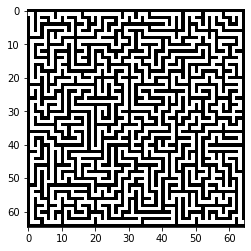

In [17]:
image = Image.open("../data/raw/maze.png")

image = np.array(image)

# manually set alpha channel
image[:,:,3] = 255-image[:,:,0]
image[:,:,:3] = 0

plt.imshow(image)

image = image/255

image = torch.Tensor(image).transpose(0,2).to(device)

img_size = 65

# Initialize model

In [18]:
n_channels = 16
hidden_size = 256

model = models.Automata((img_size, img_size), n_channels, hidden_size, device).to(device)

# Initialize pool

In [19]:
pool_size = 1024
batch_size = 16

# initialize pool with seeds
seed = torch.zeros(n_channels, img_size, img_size).to(device)
seed[3:, img_size//2, img_size//2] = 1

pool_initials = seed[None, :].repeat(pool_size, 1, 1, 1)

targets = image[None,:].repeat(batch_size,1,1,1)

# Train model

In [20]:
n_epochs = 20000
lr = 0.001

losses = []

criterion = nn.MSELoss(reduction='none')
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

for i in range(n_epochs):

    iterations = random.randint(64,96)

    pool_indices = torch.Tensor(random.sample(
        range(pool_size), batch_size)).long()

    initial_states = pool_initials[pool_indices]

    out = model(initial_states, iterations)

    phenotypes = out[:, :4].squeeze()

    optimizer.zero_grad()

    loss = criterion(phenotypes, targets)

    per_sample_loss = loss.mean((1, 2, 3))
    total_loss = per_sample_loss.mean()

    total_loss.backward()
    optimizer.step()

    # argsort the losses per sample
    ranked_loss = per_sample_loss.argsort()

    # get indices of min- and max-loss samples
    min_loss_indices = ranked_loss[:1]
    max_loss_indices = ranked_loss[1:]

    replacements = out.detach()
    replacements[max_loss_indices] = seed.clone()

    # high-loss outputs are re-tasked with
    # mapping the seed to the first image,

    # low-loss outputs are tasked with mapping
    # mapping to the other image

    pool_initials[pool_indices] = replacements

    if i % 100 == 0:

        print(i, np.log10(float(total_loss.cpu().detach())))

        torch.save(model.state_dict(), "../models/disconnected_"+str(i))

    losses.append(float(total_loss))

0 -0.8904274266607852
100 -1.281611433093031
200 -1.2944065427206333
300 -1.35135202283739
400 -1.3414742909671493
500 -1.4901129623221925
600 -1.5119731516968262
700 -1.4631995405781875
800 -1.5887572253726754
900 -1.6186934212802118
1000 -1.5416772502201557
1100 -1.641781294651836
1200 -1.6084909088711323
1300 -1.4492189454411852
1400 -1.665418025097374
1500 -1.683380445923481
1600 -1.5209808555578117
1700 -1.6120665457774732
1800 -1.6250520807537048
1900 -1.5809672650523645
2000 -1.6099410860882108
2100 -1.6334045284145218
2200 -1.6114027671308362
2300 -1.673474360323854
2400 -1.7023894269435216
2500 -1.7811224153809988
2600 -1.5329328065261383
2700 -1.7571787523292912
2800 -1.6494226248953452
2900 -1.7566438996686284
3000 -1.7609556939839868
3100 -1.8436865917268952
3200 -1.797880750148484
3300 -1.6020838976776748
3400 -1.7592820175081825
3500 -1.2715914827659707
3600 -1.2045192501060327
3700 -1.2045441501159706
3800 -1.2045884606361363
3900 -1.2048414799709506
4000 -1.204726940716

KeyboardInterrupt: 

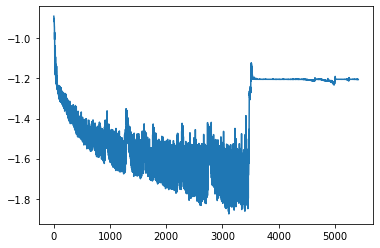

In [21]:
plt.plot(np.log10(losses))

In [179]:
video = utils.get_model_history(model, seed, 1024)
# utils.channels_to_gif("../videos/metamorphosis_channels.gif", video)
utils.colors_to_gif("../videos/disconnected_colors.gif", video)

/home/khu/anaconda3/envs/cenv/lib/python3.7/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


In [180]:
from IPython.display import HTML
HTML('<img src="../videos/disconnected_colors.gif?modified=12346">')